In [268]:
from configparser import ConfigParser
import psycopg2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [269]:
def config(filename='database.ini', section='postgresql'):
    # create a parser
    parser = ConfigParser()
    # read config file
    parser.read(filename)
  
    # get section, default to postgresql
    db = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))
  
    return db

In [270]:
def connect():
    """ Connect to the PostgreSQL database server """
    conn = None
    result = []
    try:
        # read connection parameters
        params = config()
  
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params)
          
        # create a cursor
        cur = conn.cursor()
          
    # execute a statement
        print('PostgreSQL database version:')
        cur.execute('SELECT version()')
  
        # display the PostgreSQL database server version
        db_version = cur.fetchone()
        print(db_version)
        cur.execute("""select "Value", "Date"
                       from "SheetEntities"
                       where date_part('year', "Date") = '2021' and "FullSheetName" like '%PM10_1g%'
                       and "StationName" = 'MpKrakBujaka';""")
        result = cur.fetchall()
    # close the communication with the PostgreSQL
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            print('Database connection closed.')
    return result

In [271]:
result = connect()

Connecting to the PostgreSQL database...
PostgreSQL database version:
('PostgreSQL 15.2 on aarch64-unknown-linux-musl, compiled by gcc (Alpine 12.2.1_git20220924-r4) 12.2.1 20220924, 64-bit',)
Database connection closed.


In [272]:
print(len(result))

8760


In [273]:
print(result[0])

(25.3086, datetime.datetime(2021, 1, 8, 2, 0, tzinfo=datetime.timezone.utc))


In [274]:
dt = pd.DataFrame(result, columns=["Value", "Time"])

In [275]:
dt.head()

,Value,Time
0,25.3086,2021-01-08 02:00:00+00:00
1,19.9254,2021-01-08 03:00:00+00:00
2,11.2116,2021-01-08 04:00:00+00:00
3,19.5344,2021-01-08 05:00:00+00:00
4,16.9474,2021-01-08 06:00:00+00:00


In [276]:
dt.describe()

,Value
count,8687.000000
mean,32.304097
std,25.768088
min,1.000000
25%,15.010750
50%,24.534600
75%,40.639000
max,210.378000


In [277]:
dt["Time"][0]

Timestamp('2021-01-08 02:00:00+0000', tz='UTC')

In [278]:
dt = dt.sort_values("Time").dropna().reset_index(drop=True)

In [279]:
dt["Timestamp"] = dt["Time"].apply(lambda x: int(x.timestamp()/3600))
dt["Day"] = dt["Time"].apply(lambda x: x.timetuple().tm_yday)
dt['Week'] = dt["Time"].apply(lambda x: x.isocalendar()[1])
dt['WeekDay'] = dt["Time"].apply(lambda x: x.weekday())
dt["Month"] = dt["Time"].apply(lambda x: x.month)
dt["Hours"] = dt['Time'].apply(lambda x: x.hour)

In [280]:
dt.head()

,Value,Time,Timestamp,Day,Week,WeekDay,Month,Hours
0,34.7611,2021-01-01 00:00:00+00:00,447072,1,53,4,1,0
1,57.4435,2021-01-01 01:00:00+00:00,447073,1,53,4,1,1
2,48.9413,2021-01-01 02:00:00+00:00,447074,1,53,4,1,2
3,45.9664,2021-01-01 03:00:00+00:00,447075,1,53,4,1,3
4,45.4534,2021-01-01 04:00:00+00:00,447076,1,53,4,1,4


In [281]:
dt.sample(10)

,Value,Time,Timestamp,Day,Week,WeekDay,Month,Hours
4754,27.99580,2021-07-18 16:00:00+00:00,451840,199,28,6,7,16
7018,8.72543,2021-10-22 07:00:00+00:00,454135,295,42,4,10,7
7968,4.26615,2021-11-30 23:00:00+00:00,455087,334,48,1,11,23
1599,47.58890,2021-03-08 19:00:00+00:00,448675,67,10,0,3,19
226,38.57620,2021-01-10 10:00:00+00:00,447298,10,1,6,1,10
2838,24.53460,2021-04-29 13:00:00+00:00,449917,119,17,3,4,13
3008,12.77750,2021-05-06 15:00:00+00:00,450087,126,18,3,5,15
8440,8.13232,2021-12-20 15:00:00+00:00,455559,354,51,0,12,15
3755,14.98220,2021-06-06 20:00:00+00:00,450836,157,22,6,6,20
6203,13.31590,2021-09-18 02:00:00+00:00,453314,261,37,5,9,2


In [282]:
dt.describe()

,Value,Timestamp,Day,Week,WeekDay,Month,Hours
count,8687.000000,8687.000000,8687.000000,8687.000000,8687.000000,8687.000000,8687.000000
mean,32.304097,451437.555313,182.418902,26.497870,3.008749,6.507885,11.501669
std,25.768088,2525.972193,105.248396,15.046485,1.997735,3.444892,6.922299
min,1.000000,447072.000000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,15.010750,449250.500000,91.000000,13.000000,1.000000,4.000000,6.000000
50%,24.534600,451426.000000,182.000000,26.000000,3.000000,7.000000,12.000000
75%,40.639000,453627.500000,274.000000,40.000000,5.000000,10.000000,17.000000
max,210.378000,455831.000000,365.000000,53.000000,6.000000,12.000000,23.000000


In [283]:
def plot_single_day(dt, day_number):
    data = dt.loc[dt["Day"] == day_number]
    y = data["Value"].values
    x = data["Hours"].values
    plt.plot(x, y)
    plt.ylim((0, 200))
    plt.title(f"Pollution PM10 at day: {day_number}")
    plt.xlabel("Time [h]")
    plt.ylabel("Pollution [µg/m³]")
    plt.show()

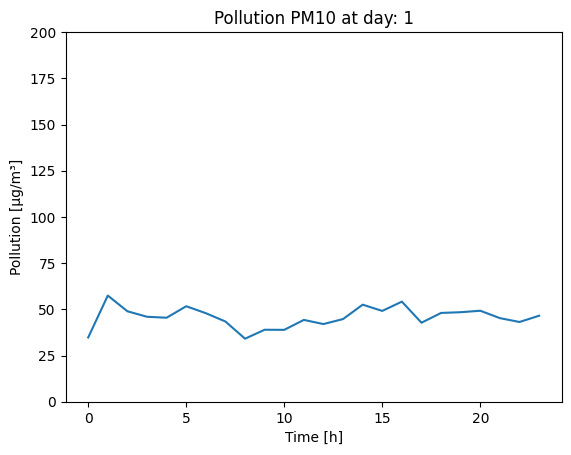

In [284]:
plot_single_day(dt, 1)

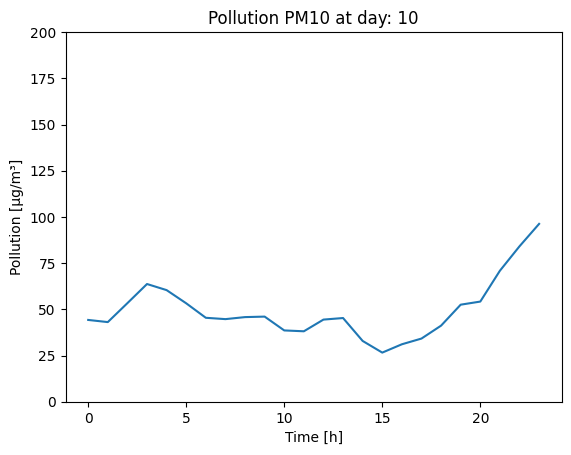

In [285]:
plot_single_day(dt, 10)

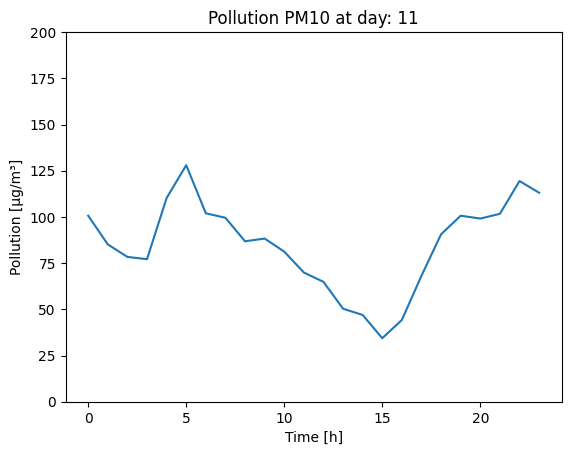

In [286]:
plot_single_day(dt, 11)

In [287]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


def plot_single_week(dt, week_number):
    data = dt.loc[dt["Week"] == week_number]
    y = data["Value"].values
    x = data["Time"]
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set_title(f"Pollution PM10 at week: {week_number}")
    ax.set_ylim((0, data["Value"].max()*1.05))
    ax.set_xlabel("Week day")
    ax.set_ylabel("Pollution [µg/m³]")
    
    formatter = mdates.DateFormatter('%a')
    ax.xaxis.set_major_formatter(formatter)
    
    plt.show()

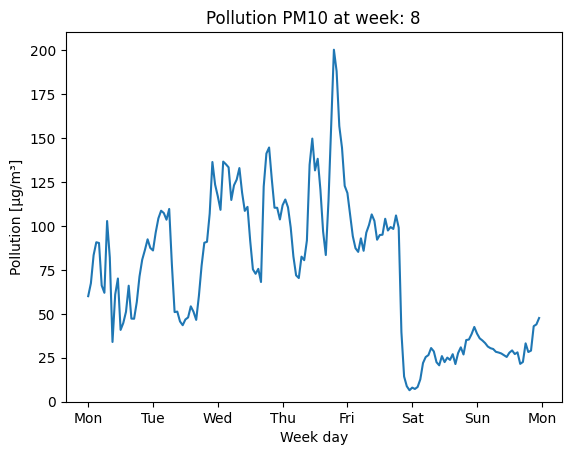

datetime64[ns, UTC]

In [288]:
plot_single_week(dt, 8)

dt["Time"].dtypes

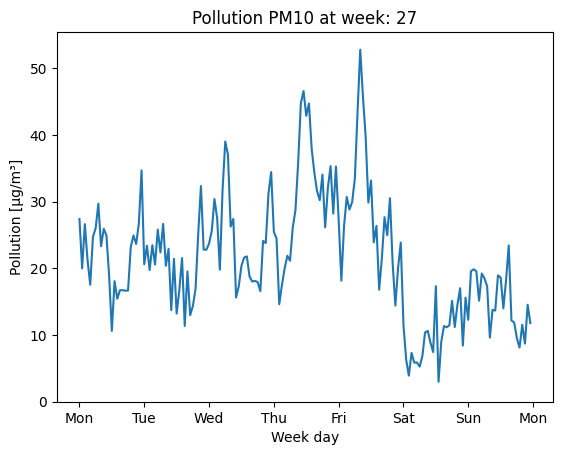

In [289]:
plot_single_week(dt, 27)

In [290]:
def plot_single_month(dt, month_number):
    data = dt.loc[dt["Month"] == month_number]
    y = data["Value"].values
    x = data["Hours"].values + data["Day"] * 24
    plt.plot(x, y)
    plt.title(f"Pollution PM10 at month: {month_number}")
    plt.ylim((0, 200))
    plt.xlabel("Time [h]")
    plt.ylabel("Pollution [µg/m³]")
    plt.show()

Pollutions for January


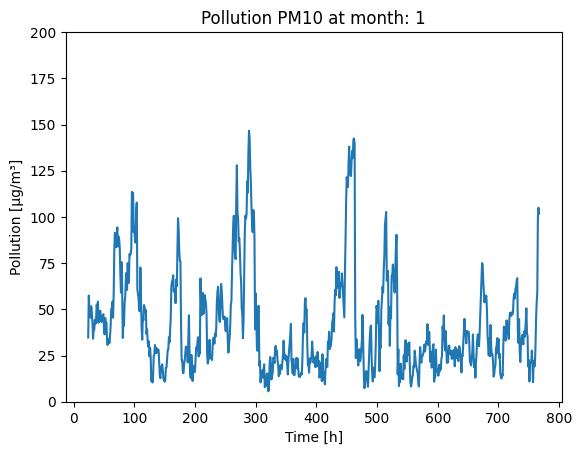

Pollutions for February


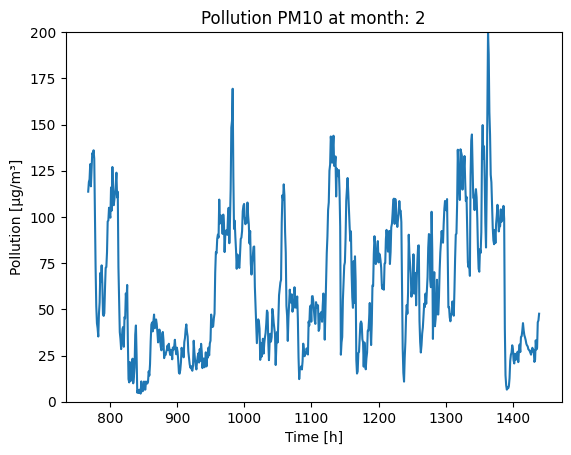

Pollutions for March


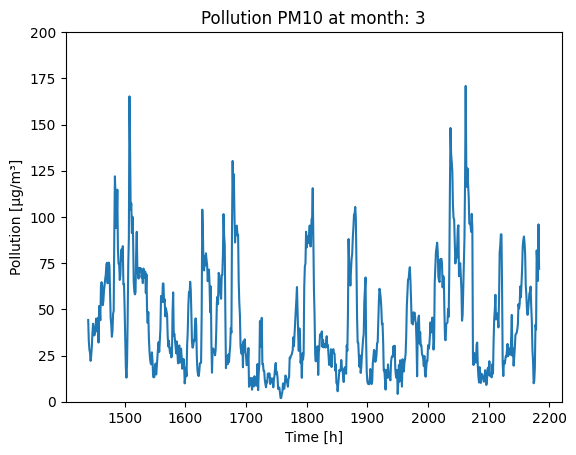

Pollutions for April


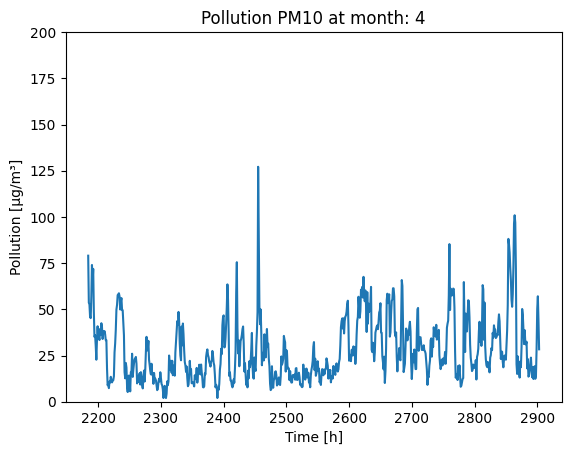

Pollutions for May


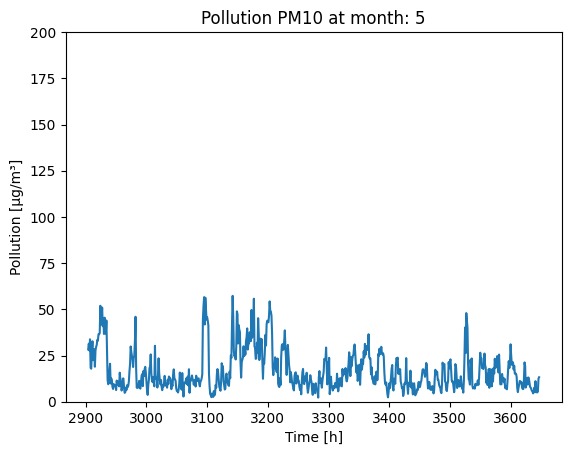

Pollutions for June


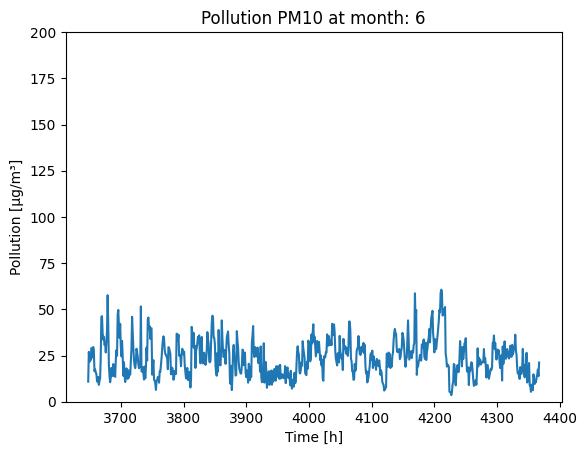

Pollutions for July


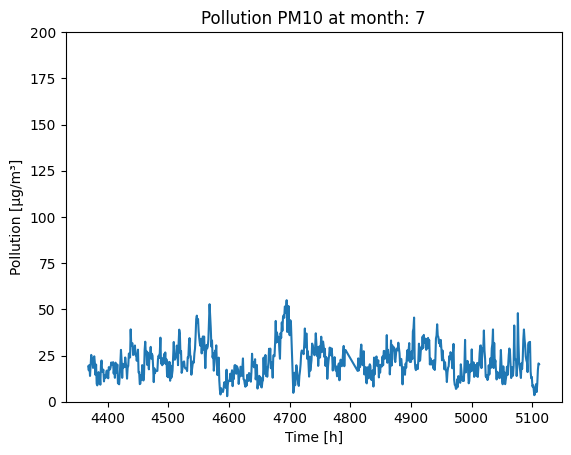

Pollutions for August


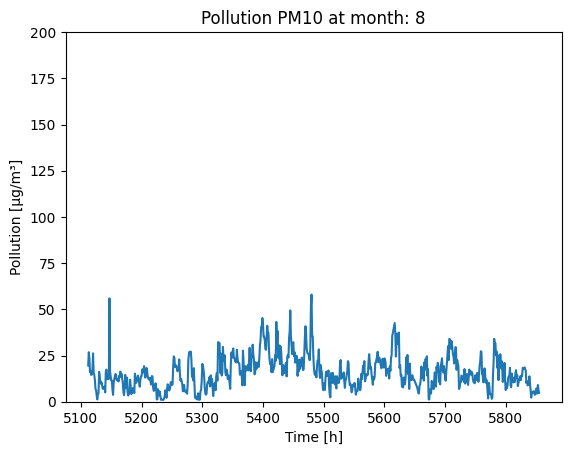

Pollutions for September


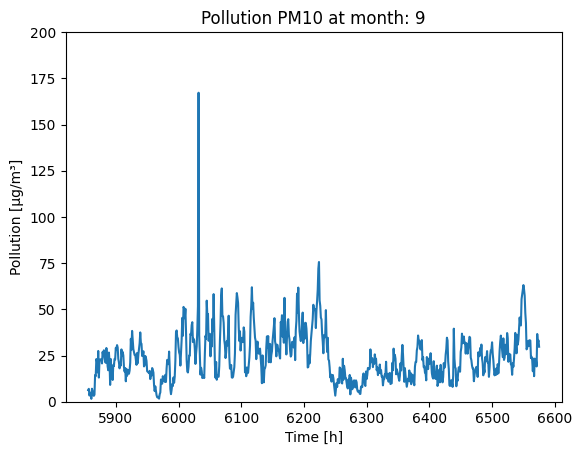

Pollutions for October


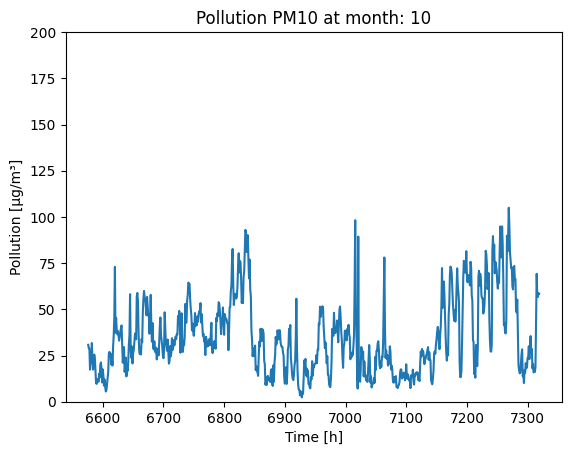

Pollutions for November


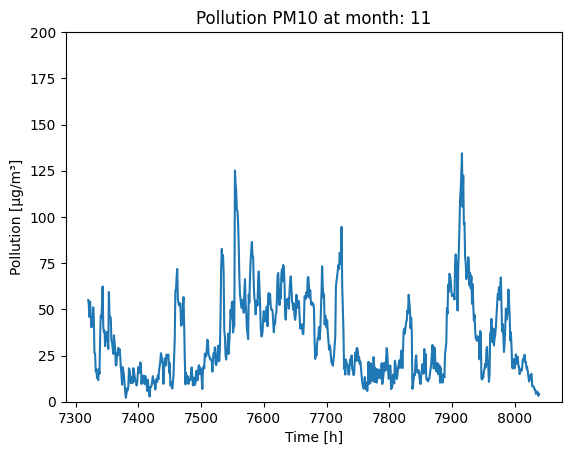

Pollutions for December


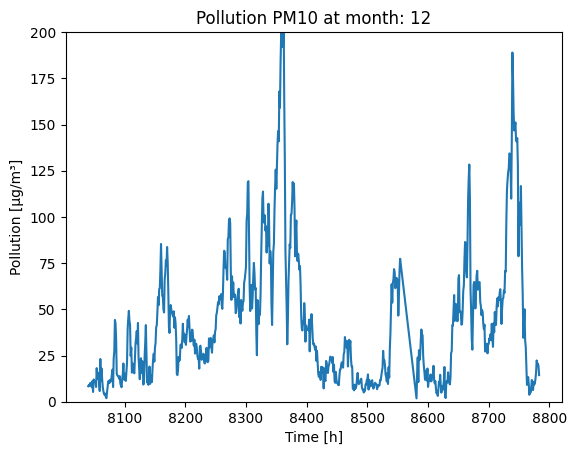

In [291]:
MONTHS = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

for i in range(1, 13):
    print(f"Pollutions for {MONTHS[i-1]}")
    plot_single_month(dt, i)

In [292]:
def plot_single_year(dt):
    y = dt["Value"].values
    #x = dt["Hours"].values + dt["Day"] * 24
    x = dt["Time"]
    _, ax = plt.subplots(figsize=(20,5))

    ax.plot(x, y)
    ax.set_title(f"Pollution PM10 during 2021")
    ax.set_ylim((0, dt["Value"].max()*1.2))
    ax.set_xlabel("Time [h]")
    ax.set_ylabel("Pollution [µg/m³]")
    formatter = mdates.DateFormatter('%B %Y')
    ax.xaxis.set_major_formatter(formatter)
    plt.show()

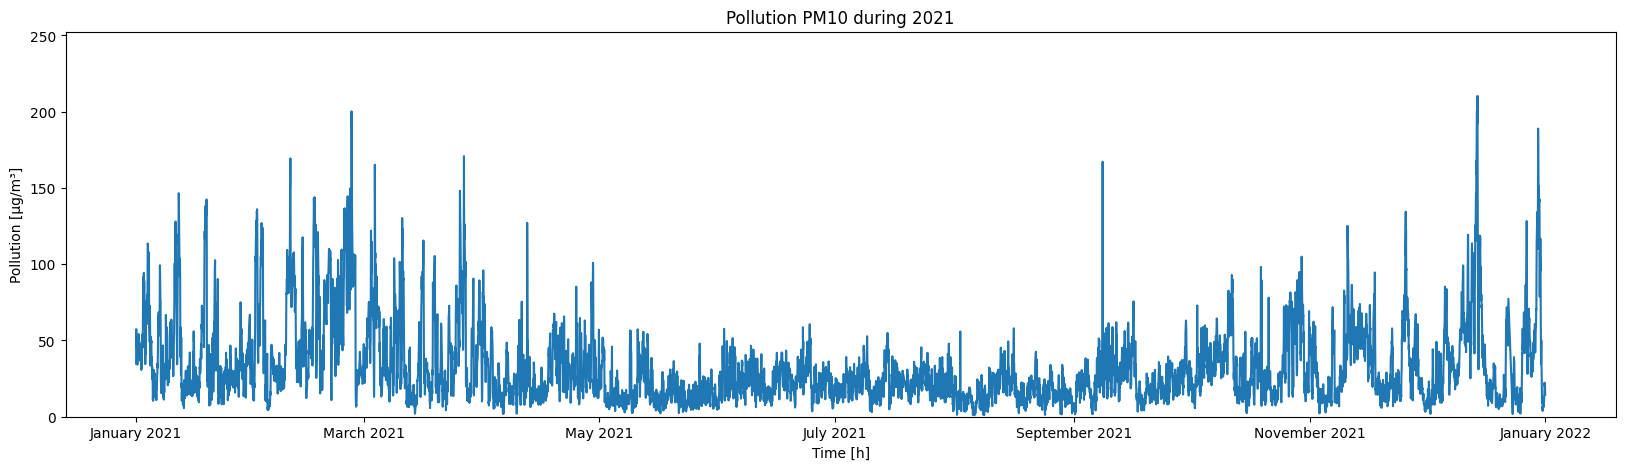

In [293]:
plot_single_year(dt)

In [294]:
def plot_week_average(dt, weeks_list):
    x = np.array(range(24*7))
    y_average = np.zeros(24*7)
    y_75 = np.zeros(24*7)
    y_25 = np.zeros(24*7)
    
    for day in range(7):
        for hour in range(24):
            data = dt.loc[(dt["Week"].isin(weeks_list)) & (dt["WeekDay"] == day) & (dt["Hours"] == hour)]
            y_average[day*24+hour] = np.average(data["Value"].values)
            y_25[day*24+hour] = np.quantile(data["Value"].values, 0.25)
            y_75[day*24+hour] = np.quantile(data["Value"].values, 0.75)
    
    _, ax = plt.subplots()
    ax.plot(x/24-3, y_average, label="Average")
    ax.plot(x/24-3, y_25, label="25%")
    ax.plot(x/24-3, y_75, label="75%")
    ax.set_title(f"Averate PM10 pollutions at week")
    ax.legend()
    ax.set_ylim((0, data["Value"].max()*1.2))
    ax.set_xlabel("Time [h]")
    ax.set_ylabel("Pollution [µg/m³]")
    formatter = mdates.DateFormatter('%a')
    ax.xaxis.set_major_formatter(formatter)
    plt.show()

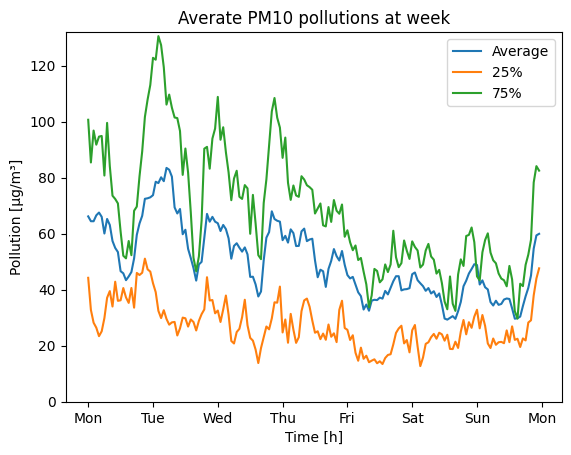

In [295]:
winter_weeks = [i for i in range(1,10)] + [i for i in range(49, 54)]
plot_week_average(dt, winter_weeks)

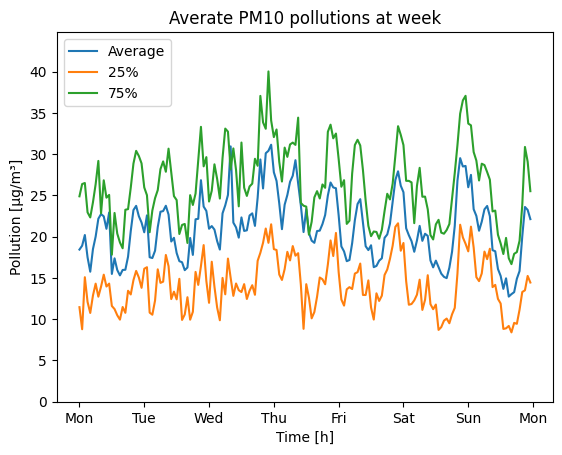

In [296]:
summer_weeks = [i for i in range(25, 40)]
plot_week_average(dt, summer_weeks)